<a href="https://colab.research.google.com/github/MattBortoletto/Measles-Information-spreading/blob/main/Project_Measles_Info.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Life Data Epidemiology 

## Project: Measles and Info spreading

Matteo Bortoletto - 1242935

Clelia Corridori - 1230664

Michele Puppin - 1227474

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import networkx as nx
import numpy as np 
from joblib import Parallel, delayed

### Define the model

In [2]:
# Erdos and Renyi Graph

def er(N,p):
   
    G = nx.Graph()    
    G.add_nodes_from(range(N))    
    edges = set()
    
    for i in range(N):        
        for j in range(N):            
            if i != j:            
                if random.random() < p:                
                    edges.add((i,j))
    
    G.add_edges_from(edges)
    
    return G

In [3]:
def SIRV(old_stateA, old_stateB, GB, betaB, gammaB, phi, p):
     
    new_stateB = old_stateB.copy()
    
    # Infection phase                
    for node in range(len(old_stateB)):
                    
        if old_stateB[node] == 'IB':
        
            l = GB.neighbors(node)

            for i in l:                
                if old_stateB[i] == 'SB':                    
                    x = random.random()                    
                    if x < betaB:
                        new_stateB[i] = 'IB'
    
    # Recovery phase                
    for node in range(len(old_stateB)):
        
        if old_stateB[node] == 'IB':
            x = random.random()
            if x < gammaB:
                new_stateB[node] = 'RB'
                
    # Vaccination phase                
    for node in range(len(old_stateB)):
                    
        if (old_stateB[node] == 'SB' and old_stateA[node] == 'IA'):
        
            l = GB.neighbors(node)
            
            count = 0
            for i in l:                
                if old_stateB[i] == 'IB': 
                    count += 1
            if count > phi:
                x = random.random()                    
                if x < p:
                    new_stateB[node] = 'VB'
       
    return new_stateB

In [4]:
def SIR(old_stateA, old_stateB, GA, betaA, gammaA):
    
    new_stateA = old_stateA.copy()
    
    # Infection phase                
    for node in range(len(old_stateA)):
                    
        if old_stateA[node] == 'IA':
        
            l = GA.neighbors(node)

            for i in l:                
                if old_stateA[i] == 'SA':                    
                    x = random.random()                    
                    if x < betaA:
                        new_stateA[i] = 'IA'
    
    # Recovery phase                
    for node in range(len(old_stateA)):
        
        if old_stateA[node] == 'IA':
            x = random.random()
            if x < gammaA:
                new_stateA[node] = 'RA'
                
     # Information phase                
    for node in range(len(old_stateA)):
        if (old_stateA[node] == 'SA' and old_stateB[node] == 'IB'):
            new_stateA[node] = 'IA'
            
    return new_stateA

In [30]:
def propagator(which_out, GA, GB, betaA, gammaA, betaB, gammaB, phi, p, t_max):

    dt = 0
    
    NB = GB.number_of_nodes()
    NA = GA.number_of_nodes()
    node_labelsB = GB.nodes()
    node_labelsA = GA.nodes()
    
    old_stateA = ['SA' for i in node_labelsA]
    old_stateB = ['SB' for i in node_labelsB]
   
    for i in range(10):
        seed = random.choice(range(NB))
        old_stateA[seed] = 'IA' 
        old_stateB[seed] = 'IB' 
    
    if which_out == "c":
        SA_frac = []
        IA_frac = []
        RA_frac = []
        SB_frac = []
        IB_frac = []
        RB_frac = []
        VB_frac = []
        
    while dt < t_max:

        #print(dt, old_stateA.count('SA'), old_stateA.count('IA'), old_stateA.count('RA'))
        #print(dt, old_stateB.count('SB'), old_stateB.count('IB'), old_stateB.count('RB'), old_stateB.count('VB'))
        
        new_stateA = SIR(old_stateA, old_stateB, GA, betaA, gammaA) 
        new_stateB = SIRV(old_stateA, old_stateB, GB, betaB, gammaB, phi, p)

        old_stateA = new_stateA.copy()
        old_stateB = new_stateB.copy()

        if which_out == "c":
            SA_frac.append(new_stateA.count('SA')/NA)
            IA_frac.append(new_stateA.count('IA')/NA)
            RA_frac.append(new_stateA.count('RA')/NA)
            SB_frac.append(new_stateB.count('SB')/NB)
            IB_frac.append(new_stateB.count('IB')/NB)
            RB_frac.append(new_stateB.count('RB')/NB)
            VB_frac.append(new_stateB.count('VB')/NB)

        elif which_out == "f":
            SA_frac = new_stateA.count('SA')/NA
            IA_frac = new_stateA.count('IA')/NA
            RA_frac = new_stateA.count('RA')/NA
            SB_frac = new_stateB.count('SB')/NB
            IB_frac = new_stateB.count('IB')/NB
            RB_frac = new_stateB.count('RB')/NB
            VB_frac = new_stateB.count('VB')/NB

        else:
            print("Not valid option!")
        
        dt += 1
    
    return (SA_frac, IA_frac, RA_frac, SB_frac, IB_frac, RB_frac, VB_frac)

In [6]:
def mean_degree(G):
    k = 0
    N = G.number_of_nodes()
    for i in range(N):
        k += G.degree[i]
    k_mean = k/N
    
    return k_mean   

In [7]:
def plot_data(res): 
     
    t = [i for i in range(len(res[0]))]

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True, figsize=(10,10))


    fig.suptitle('Network A and B')
    ax1.plot(t, res[3], label='Network B')
    ax2.plot(t, res[4], label='Network B') 
    ax3.plot(t, res[5], label='Network B')
    ax4.plot(t, res[6], label='Network B')

    ax1.plot(t, res[0], label='Network A')
    ax2.plot(t, res[1], label='Network A') 
    ax3.plot(t, res[2], label='Network A')

    ax1.set_title("Susceptible")
    ax2.set_title("Infected")
    ax3.set_title("Recovered")
    ax4.set_title("Vaccined")

    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()

    plt.show()

    return 

In [71]:
def plot_beta(betaA, betaB, RAA, RBA, VBA, RAB, RBB, VBB): 

    rows, cols = 3, 2
    fig, ax = plt.subplots(rows, cols,
                           sharex='col', 
                           sharey='row', 
                           figsize=(10,10))

    ax[0, 0].plot(betaA, RAA)
    ax[1, 0].plot(betaA, RBA) 
    ax[2, 0].plot(betaA, VBA)
    ax[0, 1].plot(betaB, RAB)
    ax[1, 1].plot(betaB, RBB) 
    ax[2, 1].plot(betaB, VBB)

    #ax[0, 0].set_ylim(0,1)
    #ax[1, 0].set_ylim(0,1)
    #ax[2, 0].set_ylim(0,1)

    ax[0, 0].grid()
    ax[1, 0].grid() 
    ax[2, 0].grid()
    ax[0, 1].grid()
    ax[1, 1].grid() 
    ax[2, 1].grid()
    
    ax[2, 0].set_xlabel(r"$\beta_A$")
    ax[2, 1].set_xlabel(r"$\beta_B$")
    
    ax[0, 0].set_ylabel(r"$R_A$")
    ax[1, 0].set_ylabel(r"$R_B$")
    ax[2, 0].set_ylabel(r"$V_B$")

    plt.show()

    return

### Parameters

In [8]:
N = 10000
kB = 8
pB = (kB/(N-1))/2
GB = er(N,pB)
kB_calc = mean_degree(GB)
print(kB_calc)

8.0174


In [9]:
kA = 8
pA = (kA/(N-1))/2
GA = er(N,pA)
kA_calc = mean_degree(GA)
print(kA_calc)

7.992


In [10]:
#betaA = 0.5
gammaA = 1

betaB = 0.5
gammaB = 1

phi = 2
p = 0.8

In [11]:
t_max = 100

In [12]:
print("kA mean:", kA_calc)
print("kB mean:", kB_calc)
#print("R0A:", R0A)
#print("R0B:", R0B)
#print("betaA:", betaA)
print("betaB:", betaB)
print("gammaA:", gammaA)
print("gammaB:", gammaB)

kA mean: 7.992
kB mean: 8.0174
betaB: 0.5
gammaA: 1
gammaB: 1


### Run the model

In [53]:
RA_list = []
RB_list = [] 
VB_list = []
RA_mean = []
RB_mean = []
VB_mean = []

betaA = np.linspace(0, 1, 100)
niterations = 10

for i in betaA:
    print("beta_A:", i)
    #res = propagator(GA, GB, bA, gammaA, betaB, gammaB, phi, p, t_max)
    res = Parallel(n_jobs=16, verbose=10)(delayed(propagator)("f", GA, GB, i, gammaA, betaB, gammaB, phi, p, t_max) for j in range(niterations))
    df = pd.DataFrame(res, columns=["SA", "IA", "RA", "SB", "IB", "RB", "VB"])
    RA_mean.append(df["RA"].mean())
    RB_mean.append(df["RB"].mean())
    VB_mean.append(df["VB"].mean())

beta_A: 0.0


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    9.7s remaining:   22.7s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:   13.3s remaining:   13.3s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   16.9s remaining:    7.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   21.6s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.010101010101010102


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    6.2s remaining:   14.6s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    9.8s remaining:    9.8s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   13.0s remaining:    5.6s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   17.4s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.020202020202020204


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.5s remaining:   12.8s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.0s remaining:    5.1s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.030303030303030304


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.0s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.6s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.04040404040404041


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.1s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.0s remaining:    5.1s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.4s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.05050505050505051


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.5s remaining:   12.9s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.4s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.06060606060606061


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.4s remaining:   12.6s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.2s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.07070707070707072


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.8s remaining:   13.5s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    9.3s remaining:    9.3s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.7s remaining:    5.4s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   17.1s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.08080808080808081


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.0s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.09090909090909091


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.0s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.10101010101010102


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.1s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.2s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.6s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.11111111111111112


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.1s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.0s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.4s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.12121212121212122


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.0s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.4s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.13131313131313133


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.1s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    9.1s remaining:    9.1s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.4s remaining:    5.3s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.8s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.14141414141414144


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.0s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    9.0s remaining:    9.0s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.15151515151515152


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.0s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.0s remaining:    5.1s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.4s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.16161616161616163


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.5s remaining:   12.9s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.0s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.4s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.17171717171717174


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.5s remaining:   12.9s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.18181818181818182


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.0s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.0s remaining:    5.1s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.3s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.19191919191919193


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.5s remaining:   12.8s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.20202020202020204


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.5s remaining:   12.8s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.0s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.3s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.21212121212121213


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.0s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.4s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.22222222222222224


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.5s remaining:   12.8s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.0s remaining:    5.1s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.4s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.23232323232323235


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.5s remaining:   12.8s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.0s remaining:    5.1s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.4s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.24242424242424243


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.0s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.25252525252525254


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.0s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.26262626262626265


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.7s remaining:   13.2s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.3s remaining:    5.3s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.6s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.27272727272727276


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.5s remaining:   12.8s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.4s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.2828282828282829


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.0s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.29292929292929293


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.5s remaining:   12.9s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.0s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.4s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.30303030303030304


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.5s remaining:   12.8s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   11.9s remaining:    5.1s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.3s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.31313131313131315


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.5s remaining:   12.9s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.0s remaining:    5.1s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.4s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.32323232323232326


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.0s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.0s remaining:    5.1s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.4s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.33333333333333337


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    9.6s remaining:   22.4s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:   12.8s remaining:   12.8s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   16.1s remaining:    6.9s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   20.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.3434343434343435


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.5s remaining:   12.8s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.2s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.3535353535353536


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.5s remaining:   12.9s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.36363636363636365


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.1s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    9.0s remaining:    9.0s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.6s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.37373737373737376


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.0s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.2s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.38383838383838387


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.1s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.393939393939394


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.1s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.4040404040404041


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.1s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.3s remaining:    5.3s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.7s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.4141414141414142


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.0s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.2s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.42424242424242425


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.5s remaining:   12.9s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.43434343434343436


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.0s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   17.4s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.4444444444444445


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.2s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    9.0s remaining:    9.0s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.3s remaining:    5.3s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   17.4s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.4545454545454546


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    6.0s remaining:   13.9s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    9.3s remaining:    9.3s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.7s remaining:    5.4s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   17.3s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.4646464646464647


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.1s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.2s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.7s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.4747474747474748


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.1s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.3s remaining:    5.3s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.6s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.48484848484848486


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.0s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.3s remaining:    5.3s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.6s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.494949494949495


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.7s remaining:   13.2s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    9.1s remaining:    9.1s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.3s remaining:    5.3s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.8s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.5050505050505051


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    6.5s remaining:   15.1s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    9.9s remaining:    9.9s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   13.1s remaining:    5.6s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   17.6s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.5151515151515152


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.1s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    9.0s remaining:    9.0s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.2s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.6s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.5252525252525253


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.7s remaining:   13.2s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.2s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.8s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.5353535353535354


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.7s remaining:   13.4s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    9.0s remaining:    9.0s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.3s remaining:    5.3s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.8s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.5454545454545455


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.1s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.3s remaining:    5.3s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.7s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.5555555555555556


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.5s remaining:   12.9s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.3s remaining:    5.3s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.6s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.5656565656565657


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.1s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    9.0s remaining:    9.0s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.2s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.6s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.5757575757575758


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.1s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    9.0s remaining:    9.0s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.2s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.6s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.5858585858585859


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.5s remaining:   12.9s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.595959595959596


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.0s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.6s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.6060606060606061


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.1s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.6s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.6161616161616162


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.7s remaining:   13.2s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.3s remaining:    5.3s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.7s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.6262626262626263


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.5s remaining:   12.9s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.2s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.6s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.6363636363636365


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.1s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    9.0s remaining:    9.0s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.3s remaining:    5.3s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   17.0s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.6464646464646465


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    6.4s remaining:   15.0s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:   10.5s remaining:   10.5s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   13.7s remaining:    5.9s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   18.2s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.6565656565656566


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.1s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    9.0s remaining:    9.0s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.2s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.7s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.6666666666666667


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.1s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.2s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.6s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.6767676767676768


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.7s remaining:   13.2s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.2s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.6s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.686868686868687


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.7s remaining:   13.2s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    9.1s remaining:    9.1s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.8s remaining:    5.5s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   17.1s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.696969696969697


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.5s remaining:   12.9s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.2s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.7070707070707072


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.1s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    9.0s remaining:    9.0s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.2s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.6s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.7171717171717172


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.7s remaining:   13.3s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    9.1s remaining:    9.1s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.2s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.7s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.7272727272727273


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.5s remaining:   12.9s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.7373737373737375


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.1s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.7474747474747475


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.0s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.4s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.7575757575757577


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.0s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.2s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.7676767676767677


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.5s remaining:   12.9s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.2s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.7777777777777778


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.0s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    9.0s remaining:    9.0s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.787878787878788


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.0s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.797979797979798


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.0s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.8080808080808082


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.0s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.8181818181818182


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.0s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.0s remaining:    5.1s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.8282828282828284


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.2s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.2s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.7s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.8383838383838385


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.5s remaining:   12.9s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.4s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.8484848484848485


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.5s remaining:   12.9s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.8585858585858587


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.5s remaining:   12.9s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.0s remaining:    5.1s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.4s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.8686868686868687


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.5s remaining:   12.9s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.0s remaining:    5.1s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.8787878787878789


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.0s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.0s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.888888888888889


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.5s remaining:   12.9s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   11.9s remaining:    5.1s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.3s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.8989898989898991


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.0s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.2s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.6s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.9090909090909092


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.5s remaining:   12.9s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.4s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.9191919191919192


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.0s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.0s remaining:    5.1s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.4s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.9292929292929294


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.0s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.9393939393939394


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.0s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.9494949494949496


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.1s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.9595959595959597


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.0s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.0s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.4s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.9696969696969697


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.5s remaining:   12.9s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.0s remaining:    5.1s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.3s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.9797979797979799


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.4s remaining:   12.6s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.0s remaining:    5.1s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.2s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 0.98989898989899


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.0s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.1s remaining:    5.2s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


beta_A: 1.0


[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    5.6s remaining:   13.0s
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:   12.0s remaining:    5.1s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:   16.4s finished


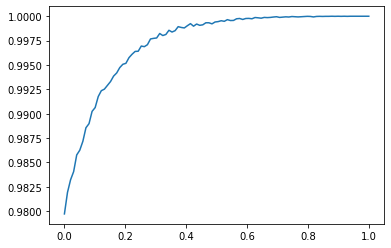

In [56]:
plt.plot(betaA, RA_mean)
plt.show()

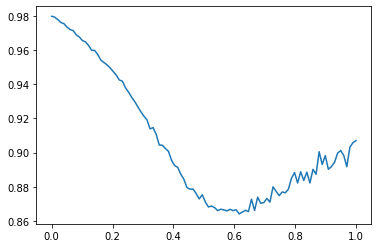

In [57]:
plt.plot(betaA, RB_mean)
plt.show()

In [55]:
rows = zip(betaA, RA_mean, RB_mean, VB_mean) 

import csv

with open("results_betaA.csv", "w") as f:
    writer = csv.writer(f)
    for row in rows:
        writer.writerow(row)

In [61]:
df = pd.read_csv("results_betaA.csv", header=None)
df.columns=["betaA", "RAA", "RBA", "VBA"] 
df

,betaA,RAA,RBA,VBA
0,0.000000,0.97972,0.97972,0.00000
1,0.010101,0.98193,0.97919,0.00138
2,0.020202,0.98322,0.97775,0.00266
3,0.030303,0.98406,0.97605,0.00379
4,0.040404,0.98577,0.97536,0.00533
...,...,...,...,...
95,0.959596,1.00000,0.89841,0.07543
96,0.969697,1.00000,0.89177,0.08049
97,0.979798,1.00000,0.90314,0.07099
98,0.989899,1.00000,0.90584,0.06834


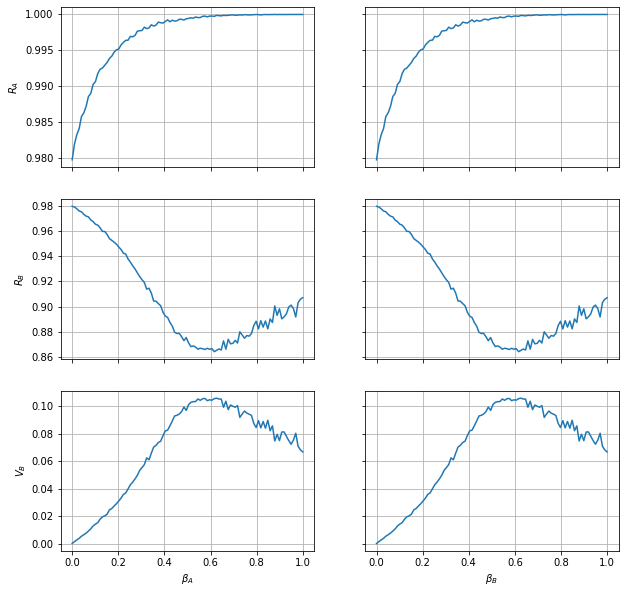

In [72]:
plot_beta(df["betaA"], df["betaA"], df["RAA"], df["RBA"], df["VBA"], df["RAA"], df["RBA"], df["VBA"]) # USATO DUE VOLTE GLI STESSI VALORI!